In [3]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

words = open('/Users/mli/Documents/Projects/karpathy/makemore-master/names.txt', 'r').read().splitlines()

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print((''.join(itos[i] for i in context), '->', itos[ix]))
        context = context[1:] + [ix]        
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
('...', '->', 'e')
('..e', '->', 'm')
('.em', '->', 'm')
('emm', '->', 'a')
('mma', '->', '.')
olivia
('...', '->', 'o')
('..o', '->', 'l')
('.ol', '->', 'i')
('oli', '->', 'v')
('liv', '->', 'i')
('ivi', '->', 'a')
('via', '->', '.')
ava
('...', '->', 'a')
('..a', '->', 'v')
('.av', '->', 'a')
('ava', '->', '.')
isabella
('...', '->', 'i')
('..i', '->', 's')
('.is', '->', 'a')
('isa', '->', 'b')
('sab', '->', 'e')
('abe', '->', 'l')
('bel', '->', 'l')
('ell', '->', 'a')
('lla', '->', '.')
sophia
('...', '->', 's')
('..s', '->', 'o')
('.so', '->', 'p')
('sop', '->', 'h')
('oph', '->', 'i')
('phi', '->', 'a')
('hia', '->', '.')


In [16]:
X.shape

torch.Size([32, 3])

In [ ]:
# two dimensional embedding for 27 chars
# can think of this as weights in a linear layer of neural net
C = torch.randn((27,2)) 

tensor([1.4581, 0.7678])

In [13]:
emb = C[X] # embedding vector of every training example
emb.shape

torch.Size([32, 3, 2])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [33]:
# torch.cat((emb[:,0,:], emb[:,1,:], emb[:,2,:]), 1)
# torch.cat(torch.unbind(emb,1), 1)
emb.view([32,6]) # most efficient

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape


torch.Size([32, 100])

In [34]:
h

tensor([[-0.9871,  0.6374,  0.9616,  ..., -0.5279, -0.7626, -0.3426],
        [-0.9148, -0.1310,  0.4295,  ..., -0.4360,  0.2433, -0.8150],
        [-0.8380,  1.0000,  0.9663,  ...,  0.1925, -0.5037,  0.9998],
        ...,
        [-0.2816,  0.9628, -0.8784,  ...,  0.5546,  0.8459,  0.9999],
        [ 0.8951,  0.6376, -0.6670,  ...,  0.9131,  0.9696,  0.9860],
        [ 0.9996, -0.8359, -0.9894,  ...,  0.9759,  0.9997,  0.8945]])

In [36]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2    
logits.shape

torch.Size([32, 27])

In [37]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()

tensor(13.7982)

In [ ]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)        
        context = context[1:] + [ix]        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [131]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits,Y)
loss

tensor(19.5052, grad_fn=<NllLossBackward0>)

In [145]:
step = 0.01
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
for i in range(10000):
    # mini batch
    ix = torch.randint(0,X.shape[0], (32,))    

    # forward
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix])    
    print(loss.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # step = lrs[i]    
    for p in parameters:
        p.data -= step * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

# print(loss.item())

2.3209567070007324
2.5604097843170166
2.2827980518341064
2.4742326736450195
2.6495323181152344
2.147784471511841
2.2311031818389893
2.491558313369751
2.57965087890625
2.3185558319091797
2.5128014087677
2.683678388595581
2.0394821166992188
2.44893479347229
2.475210428237915
2.3677752017974854
2.2598698139190674
2.450873374938965
2.364136219024658
2.318737030029297
2.5168559551239014
2.1137959957122803
2.5418074131011963
2.3883790969848633
1.988577127456665
2.330307960510254
2.5707197189331055
2.2894389629364014
2.2599806785583496
2.099757671356201
2.1257941722869873
2.373746871948242
2.352147102355957
2.3220417499542236
2.302079200744629
2.516503095626831
2.5923149585723877
2.176236867904663
2.428813934326172
2.342956781387329
2.1349666118621826
2.14520001411438
1.8086754083633423
2.024899482727051
2.3386359214782715
2.2329864501953125
2.400639295578003
2.125668525695801
2.0236563682556152
2.585890531539917
2.110139846801758
2.178788185119629
2.115757703781128
2.1153440475463867
1.96317

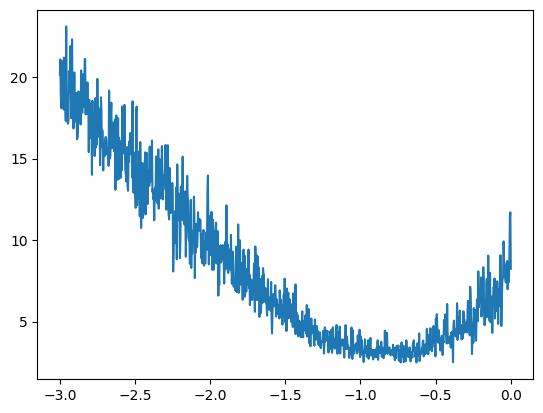

In [ ]:
# plt.plot(lri, lossi)

In [146]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y)    
loss

tensor(2.2974, grad_fn=<NllLossBackward0>)

In [ ]:
# training split, validation split, test split
# 80%, 10%, 10%

# tuning hyperparameters

In [177]:
# g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    string = ''
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        string += itos[ix]
    print(string)

calin
mona
alm
shreynemaloire
albu
emori
elvree
maimarie
raxe
yrieghen
alwenelainikko
ilitinan
rovie
sani
jalixcanian
ellahssa
royriannaw
mariu
far
zemenleynah


In [148]:
logits

tensor([[ 3.9280,  1.6945, -3.1879, -1.8591, -0.6290,  0.6747, -2.1029, -3.1173,
          0.0851,  1.3135, -3.0479, -1.7953,  0.1646, -1.7114, -0.1208,  0.3681,
         -2.3953, -4.6232, -0.1834,  0.2100, -0.0828, -0.7557, -1.2797, -4.3067,
         -3.9012,  0.0116, -2.4727]], grad_fn=<AddBackward0>)

In [149]:
logits.shape

torch.Size([1, 27])

In [151]:
probs.sum()

tensor(1., grad_fn=<SumBackward0>)